# Post processing `SPaRTA` simulations
Welcome! This is `SPaRTA` 🛡️ = SPeedy Lyman alpha Ray Tracing Algorithm. The code can be used to perform quickly MC simulations of the trajectories of absorbed Lyman alpha photons in the IGM, plotting them, and gather insights on their properties.

In this tutorial we show how to...
- Collect all the data from a `SPaRTA` simulation.
- Plot histograms of the data.
- Fit the data and plot the fit.
- Plot the multiple scattering window function.

Let us import first the package of `SPaRTA` and other packages we need for this tutorial.

In [1]:
import sparta
import numpy as np
import matplotlib.pyplot as plt

It is VERY recommended for `SPaRTA` users to have the `latex` package installed in the same python environment where `SPaRTA` is installed.
If you have latex installed then you may run the next cell, otherwise do not run it as it will raise errors and no plots in this tutorial will be shown!

In [2]:
plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"})

We also use the following color palette for this toturial (this combination is good for colorblindness).

In [3]:
import matplotlib as mpl

colors =  ['#377eb8', '#ff7f00', '#4daf4a',
           '#f781bf', '#a65628', '#984ea3',
           '#999999', '#e41a1c', '#dede00']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

In addition, the following function will be useful.

In [4]:
# Create a discrete colorbar
def add_discrete_color_bar(n_values,colors,x_labels,label,ax,inset_bounds=[0.13, 0.9, 0.8, 0.05],label_below=False):
    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(boundaries=np.arange(n_values+1)-0.5, ncolors=n_values)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    cax = ax.inset_axes(inset_bounds)
    cbar = plt.colorbar(sm, orientation='horizontal', ticks=range(n_values), cax=cax)
    cbar.ax.set_xticklabels(x_labels,fontsize=20)
    if label_below:
        cbar.ax.set_xlabel(label,fontsize=25,rotation=0,labelpad=10, ha='right', va='center')
    else:
        cbar.ax.set_ylabel(label,fontsize=25,rotation=0,labelpad=10, ha='right', va='center')
    return cbar

## Collect the data

Let us run the default simulation of `SPaRTA`. In this simulation there are 1000 photons.

In [5]:
all_photons_data = sparta.run_SPaRTA()

100%|██████████| 1000/1000 [01:12<00:00, 13.74photons/s]


In order to post-process the simulation, we need to collect all the relevant data from the simulation. This is done by creating a `SIM_DATA` object from the `ALL_PHOTONS_DATA` object. In the following command, the code will go over all the data points of all the photons in the simulation. Notice the optional `intermediate_pts` argument which enables to include intermediate points between two adjacent scatter points (by default, this argument is set to `True`). We can retrieve the intermediate data points since we know that the photon was propagating in a straight line between two successive scattering events.

In [6]:
sim_data = sparta.SIM_DATA(all_photons_data,intermediate_pts=True)

Before fitting the data, let us directly observe all of it, with `plot_scatter_all_photons`.

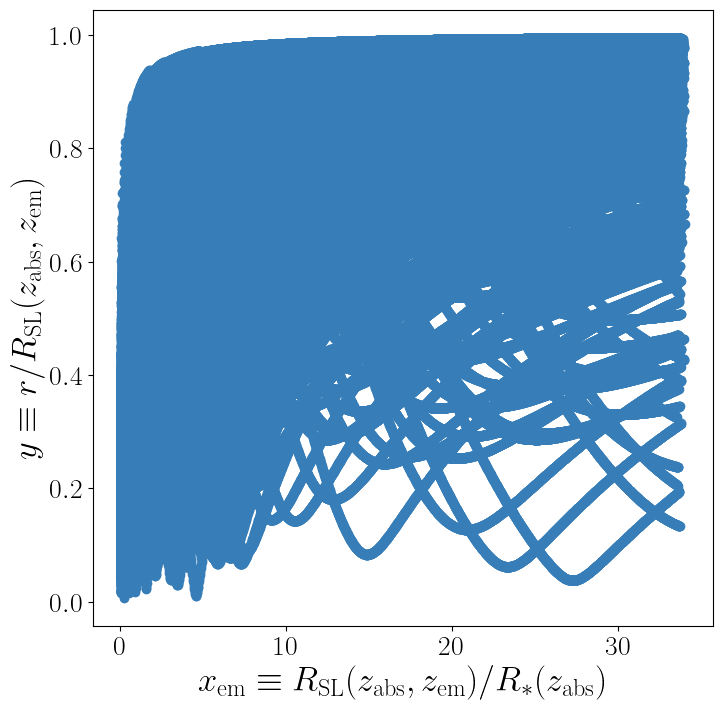

In [7]:
sim_data.plot_scatter_all_photons();

What we see in the above plot are the normalized distances of all the data points in the simulation (including the intermediate points), $y\equiv r/R_\mathrm{SL}\left(z_\mathrm{abs},z_\mathrm{em}\right)$, as a function of the normalized comoving distance, $x_\mathrm{em}\equiv R_\mathrm{SL}\left(z_\mathrm{abs},z_\mathrm{em}\right)/R_*\left(z_\mathrm{abs}\right)$, where $R_\mathrm{SL}\left(z_\mathrm{abs},z_\mathrm{em}\right)$ is the comoving distance between $z_\mathrm{abs}$ and $z_\mathrm{em}$, and $R_*\left(z_\mathrm{abs}\right)$ is the comoving diffusion scale at $z_\mathrm{abs}$.

It is actually quite difficult to understand what's going on because there are so many data points. Let us collect the data points again, but only the scatter points, without the intermediate points.

In [8]:
sim_data_no_intermediate_pts = sparta.SIM_DATA(all_photons_data,intermediate_pts=False)

This took much less time because there are no intermediate points! Now let's look on the scatter plot of all the data points, and make the horizontal axis to be on logarithmic scale for better visualization.

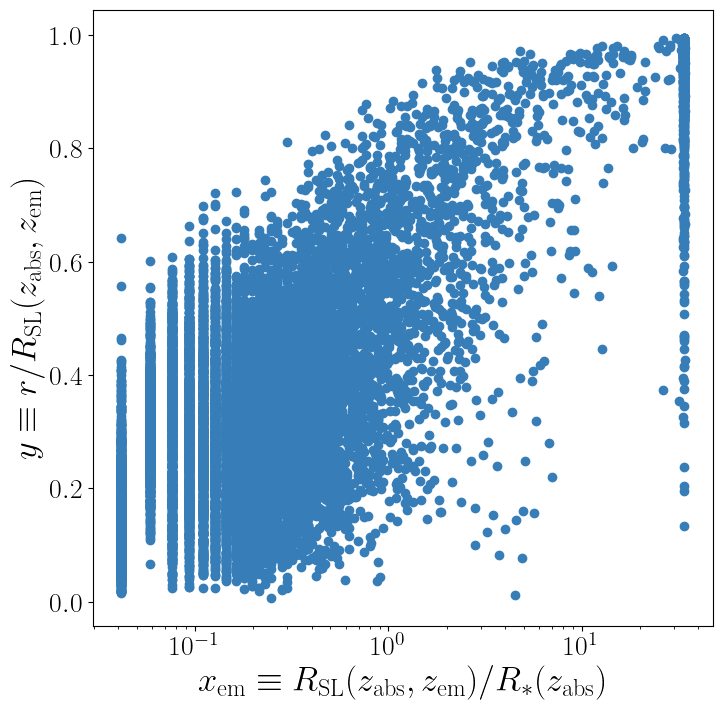

In [9]:
fig, ax = sim_data_no_intermediate_pts.plot_scatter_all_photons()
ax.set_xscale('log');

Now we can see the trend! At small $x_\mathrm{em}$ values, most data points are found below $y\sim0.6$, while $y\to1$ at high values of $x_\mathrm{em}$. We can also see that we don't have a lot of data points at the high $x_\mathrm{em}$ values, an indication that there are less scattering events in this regime (an exception occurs at the highest $x_\mathrm{em}$ value, where the apparent frequency of the photon reaches Lyman beta and the simultion ends). Because the intermediate points contain many more points, especially at the high $x_\mathrm{em}$ end, we use their data to infer the radial distributions.

We can also make similar plots for the relative velocity between emitter and absorber. We can create another `SIM_DATA` object, but this time of `kind` 'velocity'; notice that this argument can be either 'distance' or 'velocity', where 'distance' is the default, if `kind` is not specified.

In [10]:
sim_data_velocity = sparta.SIM_DATA(all_photons_data, quantity="velocity")

And as before, we can plot all the data points, this time they contain the information of $v_\mathrm{rel}^{||}/c$.

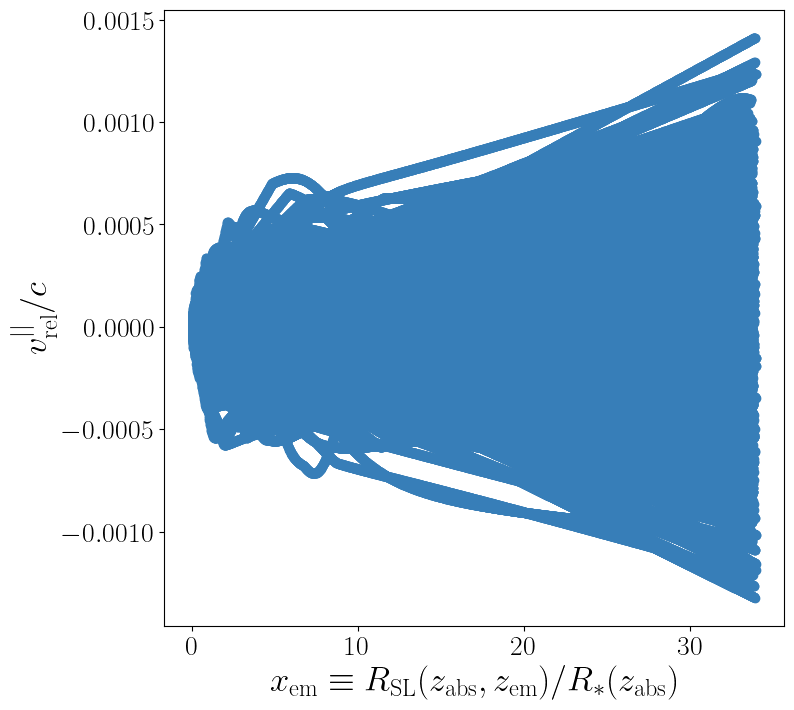

In [11]:
sim_data_velocity.plot_scatter_all_photons();

Even with the presence of the intermediate points in the plot, the trend is very clear: it appears that $v_\mathrm{rel}^{||}/c$ distributes as a Gaussian with mean zero and with variance that increases with $x_\mathrm{em}$.

## Bin the data into a histogram

To see the statistical properties of the distributions more clearly, we can bin the data. Since the data is 2D, we can make a 2D histogram with `get_histogram`. There are two arguments that control the resulting 2D histogram. The first one is `x_res`, which determines the width of the $x_\mathrm{em}$ bins. The second argument is `N_bins`, which controls how many bins there are along the $y$-axis of the data (or the $v_\mathrm{rel}^{||}/c$-axis, in case the `kind` of the collected data is 'velocity').

In [12]:
histogram_data = sim_data.get_histogram(x_res = 0.1, N_bins=12) # These are the default values

`histograms_data` is an object of type `HISTOGRAM_DATA`. Given this object and a chosen $x_\mathrm{em}$ value, we can easily plot the 1D histogram along the $y$-axis with `plot_histogram`.

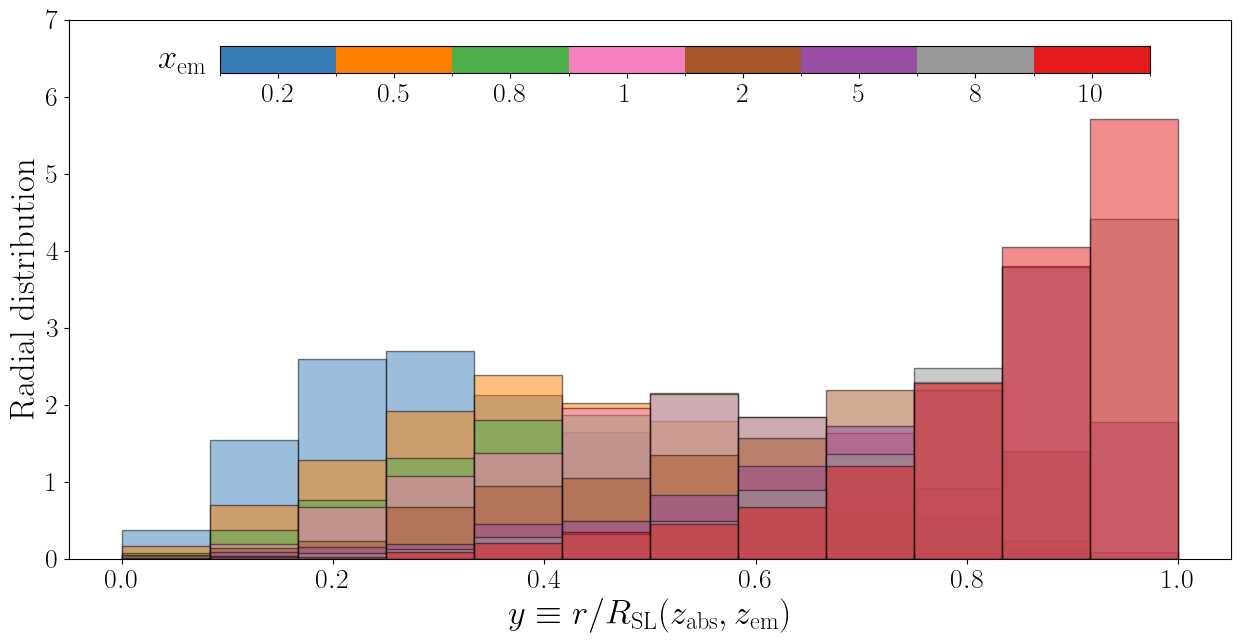

In [13]:
x_em_list = [0.2, 0.5, 0.8, 1., 2., 5., 8., 10.]
fig, ax = plt.subplots(1, 1, figsize=(15,7))
for ind, x_em in enumerate(x_em_list):
    fig, ax = histogram_data.plot_histogram(x_em=x_em, ax=ax, color=colors[ind], alpha=0.5)
ax.set_ylim([0,7])
# add discrete color bar at the top
x_labels =[f"{x_em:.1f}" if x_em < 1. else f"{x_em:.0f}" for x_em in x_em_list]
cbar = add_discrete_color_bar(n_values=len(x_em_list),colors=colors,x_labels=x_labels,label="$x_\\mathrm{em}$",ax=ax);

The trend we saw when we plotted the scatter plot is now much more visible: the histogram's center shifts to higher (lower) values of $y$ when higher (lower) values of $x_\mathrm{em}$ are considered.

The different histogram shapes can be modeled with the beta distribution,
\begin{equation*}
f\left(y\right)=\frac{y^{\alpha-1}\left(1-y\right)^{\beta-1}}{\mathrm{B}\left(\alpha,\beta\right)},
\end{equation*}
where $\alpha$ and $\beta$ are parameters of the distribution.

To see this more clearly, let us plot some beta distributions.

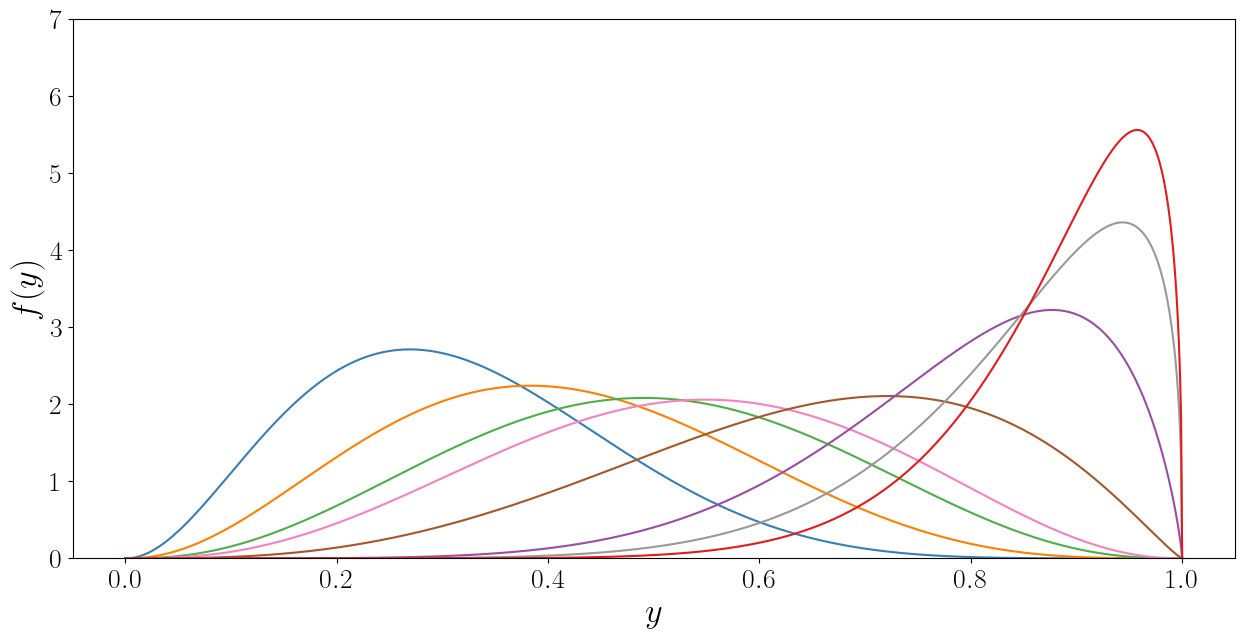

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15,7))
fig, ax = sparta.plot_beta_distribution(alpha=3.1,beta=6.7,ax=ax)
fig, ax = sparta.plot_beta_distribution(alpha=3.3,beta=4.7,ax=ax)
fig, ax = sparta.plot_beta_distribution(alpha=3.6,beta=3.7,ax=ax)
fig, ax = sparta.plot_beta_distribution(alpha=3.8,beta=3.3,ax=ax)
fig, ax = sparta.plot_beta_distribution(alpha=4.1,beta=2.2,ax=ax)
fig, ax = sparta.plot_beta_distribution(alpha=6.7,beta=1.8,ax=ax)
fig, ax = sparta.plot_beta_distribution(alpha=7.7,beta=1.4,ax=ax)
fig, ax = sparta.plot_beta_distribution(alpha=10.0,beta=1.4,ax=ax)
ax.set_ylim([0,7])
ax.set_xlabel('$y$',fontsize=25)
ax.set_ylabel('$f(y)$',fontsize=25);

This looks kinda similar to the shapes of the above histograms, right? We can fit directly the histograms to beta distributions with `fit_histogram`. Here's an example.

In [15]:
x_em = 0.8
(alpha, beta), _ = histogram_data.fit_histogram(x_em=x_em)
print(f"Best fit parameters for histogram at x_em={x_em}: alpha={alpha}, beta={beta}")

Best fit parameters for histogram at x_em=0.8: alpha=3.6233556126020896, beta=3.674834271580672


We can plot the best fit of the histograms with `plot_histogram_fit`. 

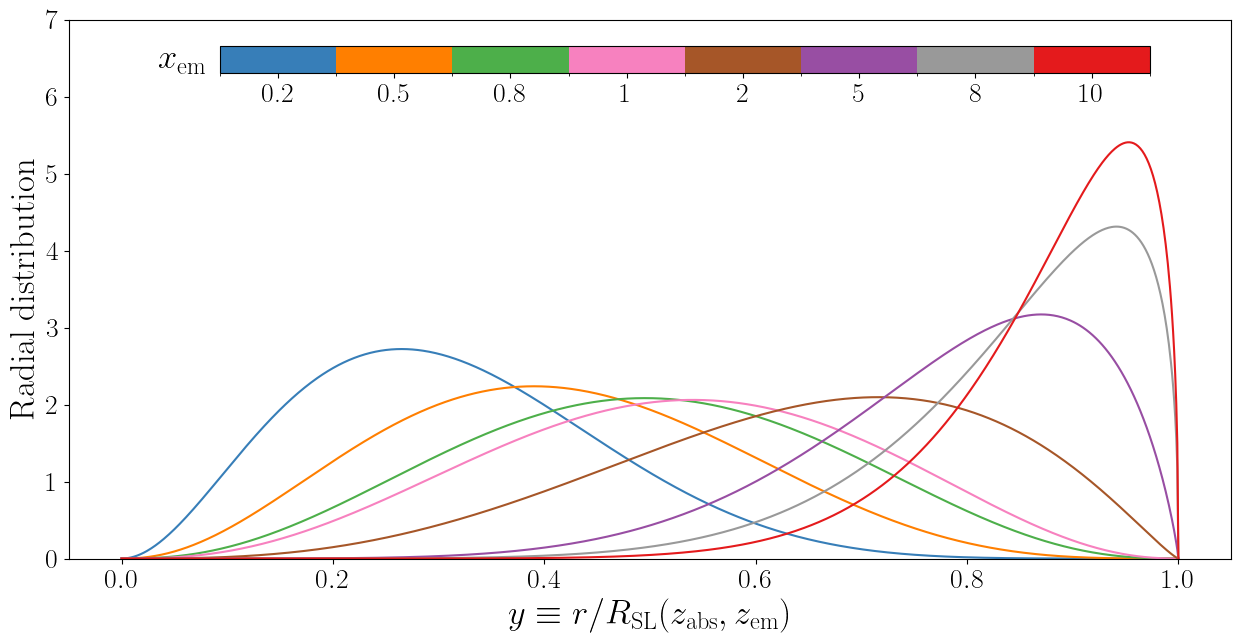

In [16]:
x_em_list = [0.2, 0.5, 0.8, 1., 2., 5., 8., 10.]
fig, ax = plt.subplots(1, 1, figsize=(15,7))
for ind, x_em in enumerate(x_em_list):
    fig, ax = histogram_data.plot_histogram_fit(x_em=x_em, ax=ax, color=colors[ind])
ax.set_ylim([0,7])
# add discrete color bar at the top
x_labels =[f"{x_em:.1f}" if x_em < 1. else f"{x_em:.0f}" for x_em in x_em_list]
cbar = add_discrete_color_bar(n_values=len(x_em_list),colors=colors,x_labels=x_labels,label="$x_\\mathrm{em}$",ax=ax);

We can also bin the data of the relative velocity with `get_histogram`. Here, we increase the number of bins along the $v_\mathrm{rel}^{||}/c$ axis.

In [17]:
histogram_data_velocity = sim_data_velocity.get_histogram(N_bins=80)

And we can plot the velocity histograms with `plot_histogram`.

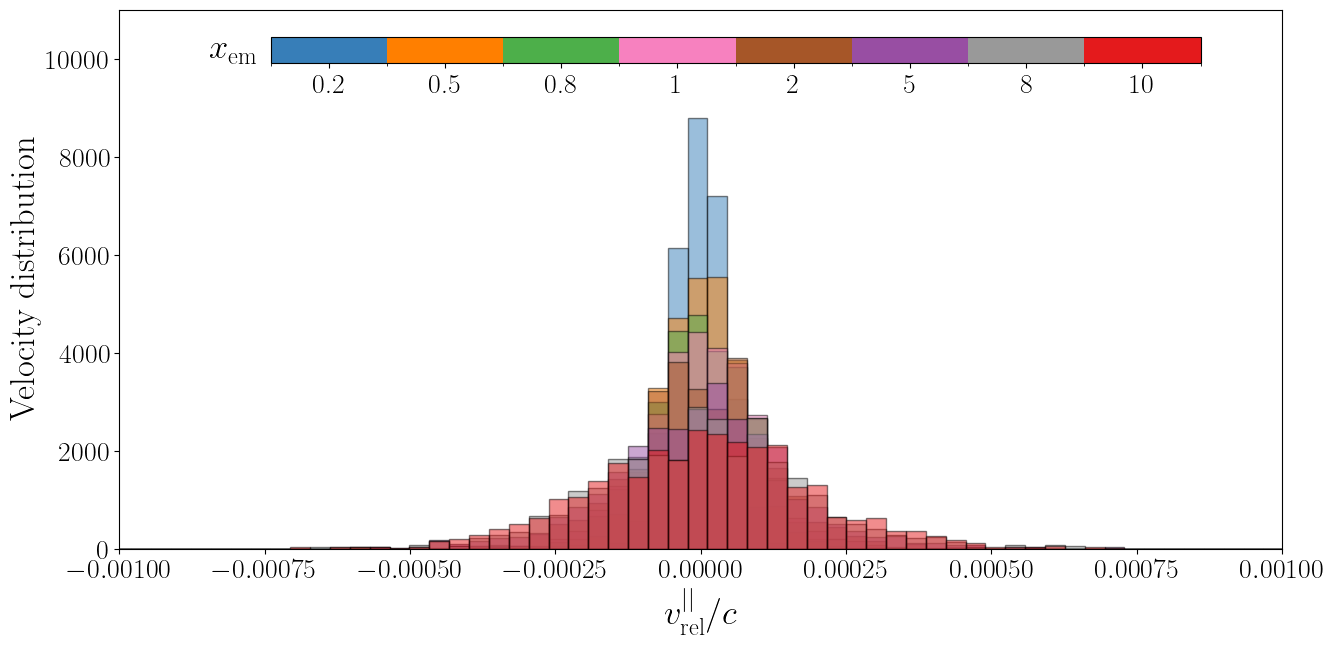

In [18]:
x_em_list = [0.2, 0.5, 0.8, 1., 2., 5., 8., 10.]
fig, ax = plt.subplots(1, 1, figsize=(15,7))
for ind, x_em in enumerate(x_em_list):
    fig, ax = histogram_data_velocity.plot_histogram(x_em=x_em, ax=ax, color = colors[ind],alpha=0.5)
ax.set_xlim([-1e-3,1e-3])
ax.set_ylim([0,11000])
# add discrete color bar at the top
x_labels =[f"{x_em:.1f}" if x_em < 1. else f"{x_em:.0f}" for x_em in x_em_list]
cbar = add_discrete_color_bar(n_values=len(x_em_list),colors=colors,x_labels=x_labels,label="$x_\\mathrm{em}$",ax=ax);

Again, we can see now the Gaussian features of the data much more clearly!

Just like we did with data of `kind` 'distance', we can plot the Gaussian best fit of the velocity histograms with `plot_histogram_fit`.

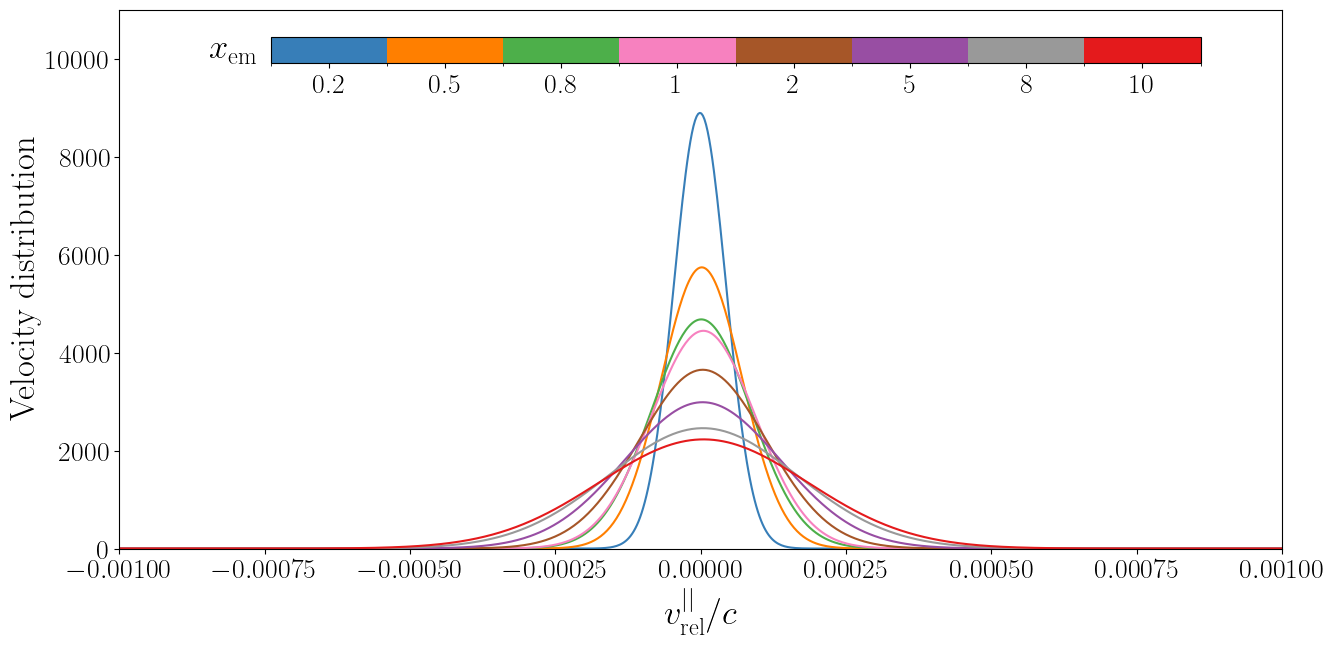

In [19]:
x_em_list = [0.2, 0.5, 0.8, 1., 2., 5., 8., 10.]
fig, ax = plt.subplots(1, 1, figsize=(15,7))
for ind, x_em in enumerate(x_em_list):
    fig, ax = histogram_data_velocity.plot_histogram_fit(x_em=x_em, ax=ax, color = colors[ind])
ax.set_xlim([-1e-3,1e-3])
ax.set_ylim([0,11000])
# add discrete color bar at the top
x_labels =[f"{x_em:.1f}" if x_em < 1. else f"{x_em:.0f}" for x_em in x_em_list]
cbar = add_discrete_color_bar(n_values=len(x_em_list),colors=colors,x_labels=x_labels,label="$x_\\mathrm{em}$",ax=ax);

## Fit the data

While fitting the histograms can give insights on the radial distributions, this fit is subject to the number and width of the bins we used, especially at high $x_\mathrm{em}$ values where the distribution tends towards $y\to1$. It is therefore better to fit the data directly, instead of fitting the histogram.

Below we find the fitting parameters of the beta distribution for $x_\mathrm{em}=30$. In order to do that directly from the data, we call `find_fitting_params`, which still bins the data along the $x_\mathrm{em}$ axis, but not along the $y$-axis! Since we bin along the $x_\mathrm{em}$ axis, we can control as before the width of the bins with the `x_res` argument.

In [20]:
x_em = 30
(alpha, beta), _ = histogram_data.fit_histogram(x_em=x_em)
print(f"Best fit parameters for histogram at x_em={x_em}: alpha={alpha}, beta={beta}")
(alpha, beta), _ = sim_data.find_fitting_params(x_em=x_em, x_res=0.1)
print(f"Best fit parameters for data at x_em={x_em}: alpha={alpha}, beta={beta}")

Best fit parameters for histogram at x_em=30: alpha=57.01093178071713, beta=3.732070364051179
Best fit parameters for data at x_em=30: alpha=4.329053982447838, beta=0.4060901593288324


Notice the differences between the two methods!

We can plot the beta distributions with the fitted parameters from the data with `plot_fit`. Notice that at small $x_\mathrm{em}$ values the distributions are similar, but they behave quite differently at high $x_\mathrm{em}$ values. Again, this discrepancy is due to binning artifacts in the histogram.

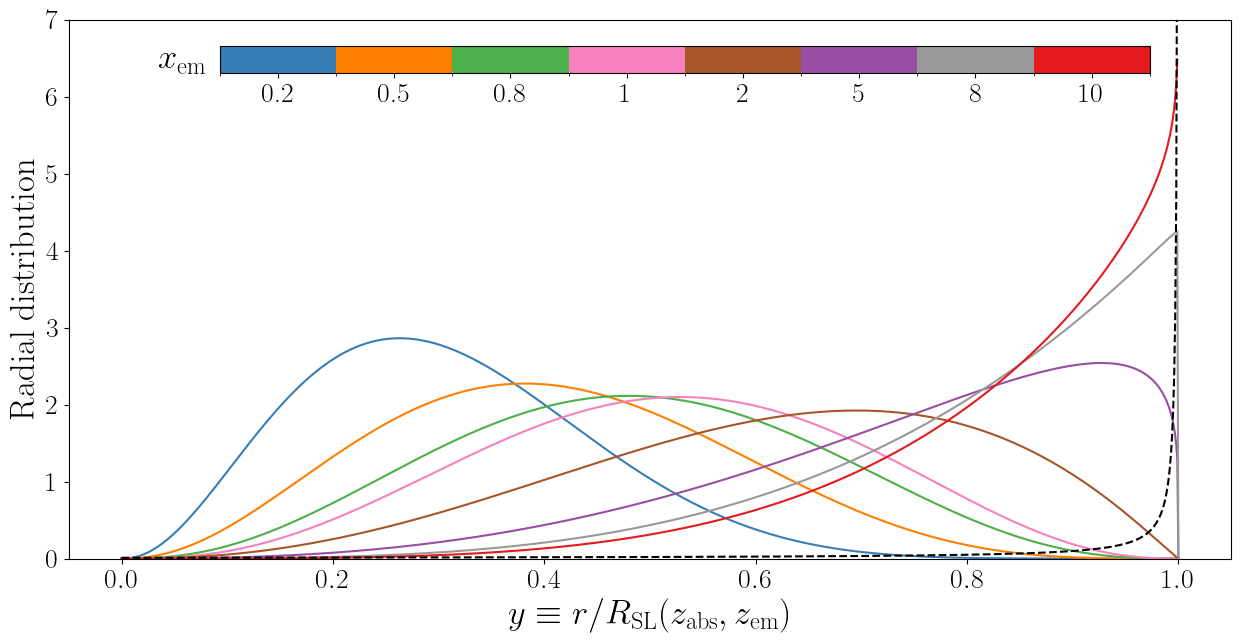

In [21]:
x_em_list = [0.2, 0.5, 0.8, 1., 2., 5., 8., 10.]
fig, ax = plt.subplots(1, 1, figsize=(15,7))
for ind, x_em in enumerate(x_em_list):
    fig, ax = sim_data.plot_fit(x_em=x_em, ax=ax, color=colors[ind])
fig, ax = sparta.plot_beta_distribution(alpha=1, beta=1e-2, ax=ax, color='k', ls ='--') # Plot a "Dirac delta function"
ax.set_ylim([0,7])
# add discrete color bar at the top
x_labels =[f"{x_em:.1f}" if x_em < 1. else f"{x_em:.0f}" for x_em in x_em_list]
cbar = add_discrete_color_bar(n_values=len(x_em_list),colors=colors,x_labels=x_labels,label="$x_\\mathrm{em}$",ax=ax);

Note that we plotted with a black dashed line a "Dirac delta function". That curve was obtained by plotting a beta distribution with $\alpha\gg\beta$. Indeed, this is the physical limit of the radial distributions when $x_\mathrm{em}\to\infty$, namely when photons arrive from distances much larger than the diffusion scale.

Similarly, we can fit directly the velocity data and plot the fitted Gaussian distributions.

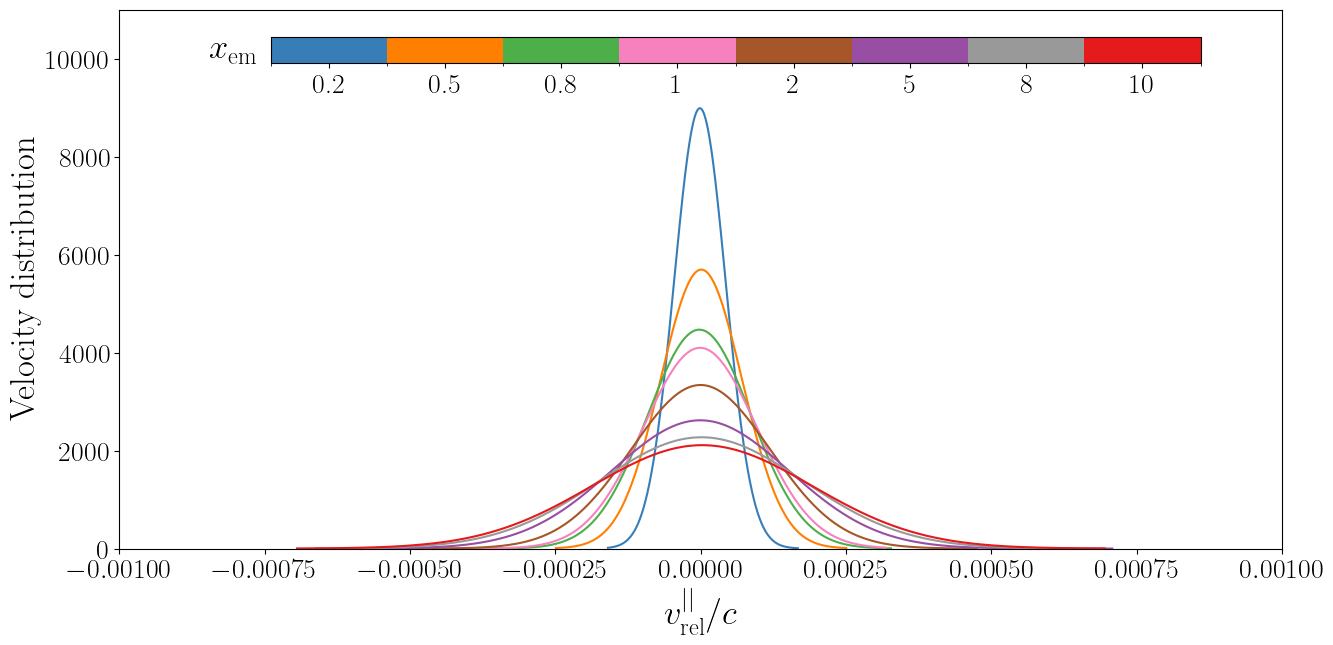

In [22]:
x_em_list = [0.2, 0.5, 0.8, 1., 2., 5., 8., 10.]
fig, ax = plt.subplots(1, 1, figsize=(15,7))
for ind, x_em in enumerate(x_em_list):
    fig, ax = sim_data_velocity.plot_fit(x_em=x_em, ax=ax, color = colors[ind])
ax.set_xlim([-1e-3,1e-3])
ax.set_ylim([0,11000])
# add discrete color bar at the top
x_labels =[f"{x_em:.1f}" if x_em < 1. else f"{x_em:.0f}" for x_em in x_em_list]
cbar = add_discrete_color_bar(n_values=len(x_em_list),colors=colors,x_labels=x_labels,label="$x_\\mathrm{em}$",ax=ax);

## Plot the window function

For numerical considerations, the more useful function is not the radial distribution, but the window function. This can be thought of as the Fourier transform of the commulative radial distribution. Mathematically, it is given by
\begin{equation*}
M\left(kR\right)=\frac{3}{k^3R^3}\int_0^{kR}dxx^{2}W\left(x\right),\qquad\text{where}\qquad W\left(x\right)=\frac{\int_{0}^{1}dyy^{2}f\left(y\right)\frac{\sin xy}{xy}}{\int_{0}^{1}dyy^{2}f\left(y\right)}
\end{equation*}

For example, in the straight-line limit, the distribution for the normalized distance $y$ is assumed to be $\delta^\mathrm{D}\left(y-1\right)$, and so the corresponding window function in that case is
\begin{equation*}
M_\mathrm{SL}\left(kR\right)=\frac{3\left(\sin kR-kR\cos kR\right)}{k^3R^3}.
\end{equation*}
However, for the multiple-scattering beta distribution, the window function is the hypergeometric function,
\begin{equation*}
M_\mathrm{MS}\left(kR\right)={_2F_{3}}\left(\frac{2+\alpha}{2},\frac{3+\alpha}{2};\frac{5}{2},\frac{2+\alpha+\beta}{2},\frac{3+\alpha+\beta}{2};-\frac{1}{4}k^2R^2\right).
\end{equation*}
In the limit $\alpha\gg\beta$, these two window functions are the same!

We can plot the window function that corresponds to the fitted beta distribution from the data with `plot_window function`.

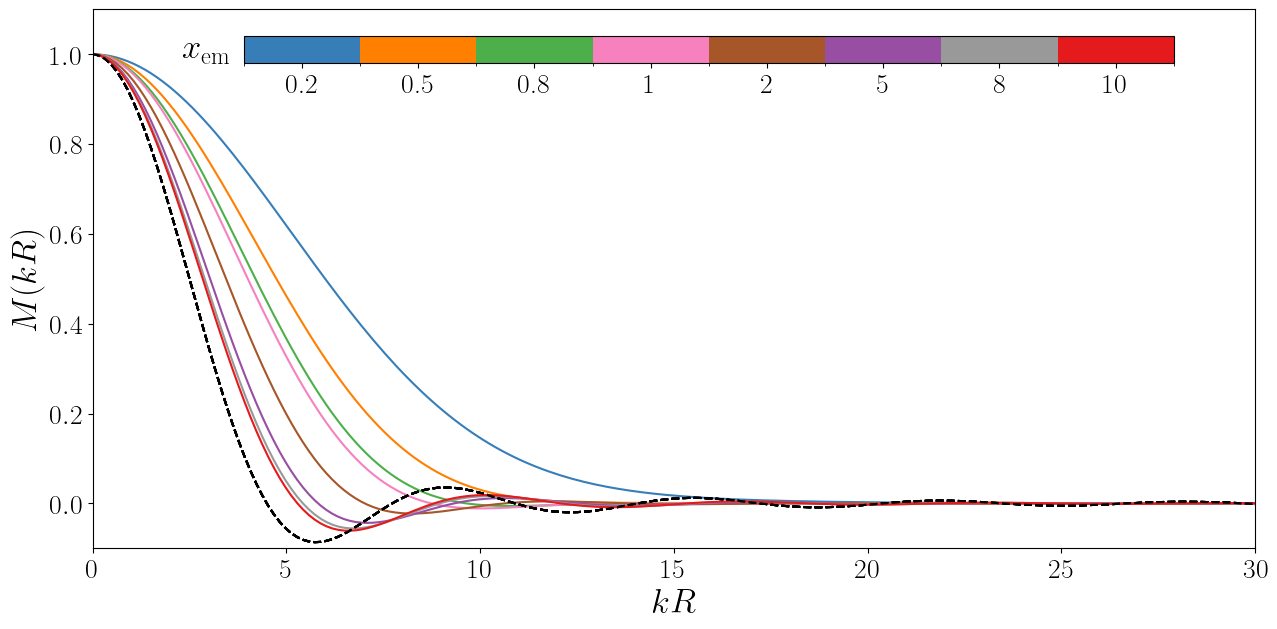

In [23]:
x_em_list = [0.2, 0.5, 0.8, 1., 2., 5., 8., 10.]
fig, ax = plt.subplots(1, 1, figsize=(15,7))
for ind, x_em in enumerate(x_em_list):
    fig, ax = sim_data.plot_window_function(x_em=x_em, ax=ax, color = colors[ind])
    fig, ax = sparta.plot_window_function(alpha=1, beta=0, ax=ax, color='k', ls ='--')
ax.set_ylim([-0.1,1.1])
# add discrete color bar at the top
x_labels =[f"{x_em:.1f}" if x_em < 1. else f"{x_em:.0f}" for x_em in x_em_list]
cbar = add_discrete_color_bar(n_values=len(x_em_list),colors=colors,x_labels=x_labels,label="$x_\\mathrm{em}$",ax=ax);

Notice that we have plotted above the straight-line window function by a black dashed line (this was done by setting $\beta=0$). Indeed, the multiple-scattering window function approaches the straight-line window function when $x_\mathrm{em}\to\infty$.

## Bonus - study the effect of peculiar velocity

Let us make another run of `SPaRTA`, but this time we turn off the effect of peculiar velocities (namely, we set them to be zero). Notice that it takes much less time for the simulation to finish, since there is no need to draw random (but correlated) velocities.

In [24]:
all_photons_data_without_v = sparta.run_SPaRTA(INCLUDE_VELOCITIES=False)

100%|██████████| 1000/1000 [00:19<00:00, 50.71photons/s]


And let us collect all the data from the simulation.

In [25]:
sim_data_without_v = sparta.SIM_DATA(all_photons_data_without_v)

Now that we have the two `SIM_DATA` objects, we can make a comparison! Let us start with the radial distributions.

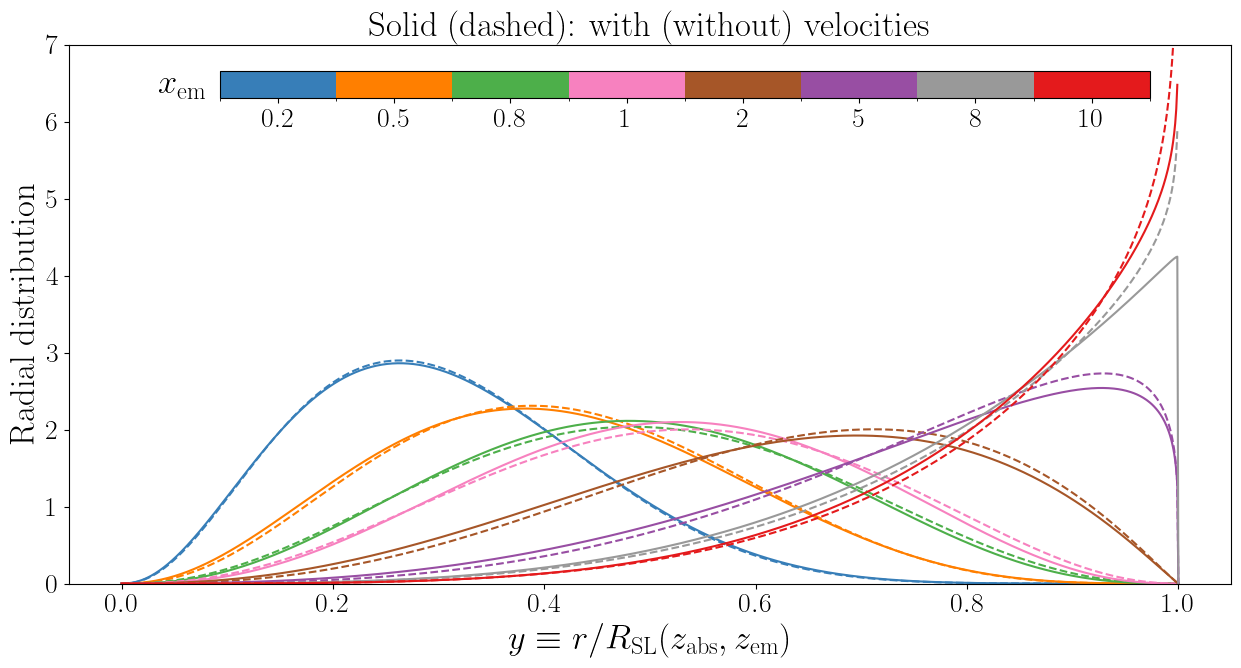

In [26]:
x_em_list = [0.2, 0.5, 0.8, 1., 2., 5., 8., 10.]
fig, ax = plt.subplots(1, 1, figsize=(15,7))
for ind, x_em in enumerate(x_em_list):
    fig, ax = sim_data.plot_fit(x_em=x_em, ax=ax, color=colors[ind])
    fig, ax = sim_data_without_v.plot_fit(x_em=x_em, ax=ax, color=colors[ind], ls='--')
ax.set_ylim([0,7])
ax.set_title("Solid (dashed): with (without) velocities",fontsize=25)
# add discrete color bar at the top
x_labels =[f"{x_em:.1f}" if x_em < 1. else f"{x_em:.0f}" for x_em in x_em_list]
cbar = add_discrete_color_bar(n_values=len(x_em_list),colors=colors,x_labels=x_labels,label="$x_\\mathrm{em}$",ax=ax);

And now we make a comparison between the window functions.

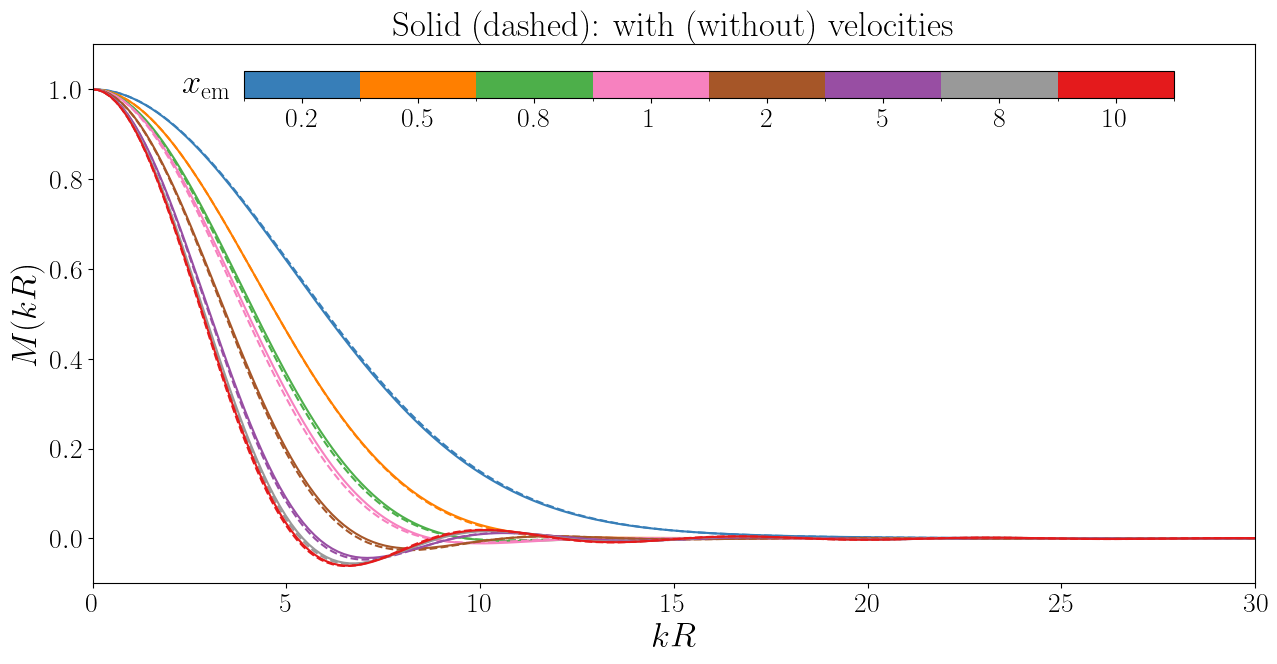

In [27]:
x_em_list = [0.2, 0.5, 0.8, 1., 2., 5., 8., 10.]
fig, ax = plt.subplots(1, 1, figsize=(15,7))
for ind, x_em in enumerate(x_em_list):
    fig, ax = sim_data.plot_window_function(x_em=x_em, ax=ax, color = colors[ind])
    fig, ax = sim_data_without_v.plot_window_function(x_em=x_em, ax=ax, color = colors[ind], ls='--')
ax.set_ylim([-0.1,1.1])
ax.set_title("Solid (dashed): with (without) velocities",fontsize=25)
# add discrete color bar at the top
x_labels =[f"{x_em:.1f}" if x_em < 1. else f"{x_em:.0f}" for x_em in x_em_list]
cbar = add_discrete_color_bar(n_values=len(x_em_list),colors=colors,x_labels=x_labels,label="$x_\\mathrm{em}$",ax=ax);

Interestingly, it seems like the peculiar velocities have no efect on the window functions. Why is that? In order to better understand the underlying physics, we plot on the left panel the relative velocity distribution that we have plotted before, and on the right panel, we plot how the relative velocity modifies the cross-section.

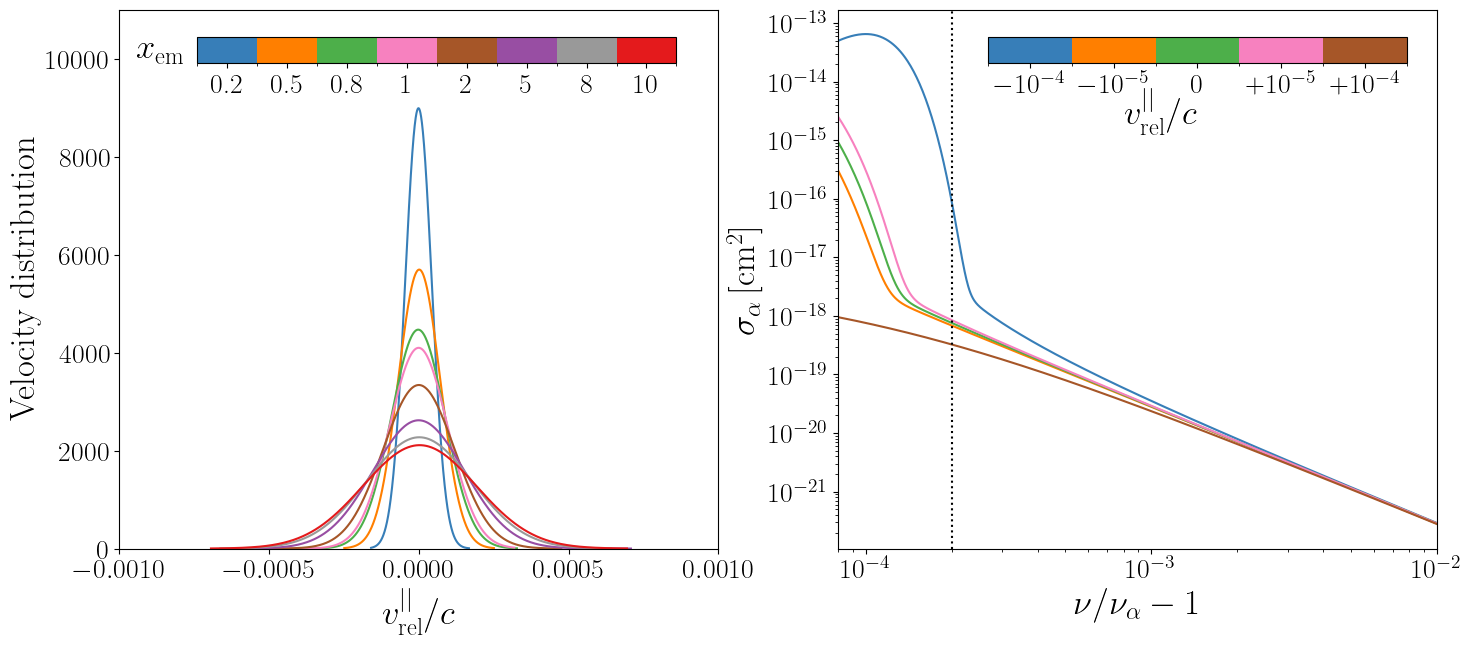

In [28]:
fig, axes = plt.subplots(1,2,figsize=(17,7))
# Plot relative velocity distribution on the left panel
ax = axes[0]
x_em_list = [0.2, 0.5, 0.8, 1., 2., 5., 8., 10.]
for ind, x_em in enumerate(x_em_list):
    fig, ax = sim_data_velocity.plot_fit(x_em=x_em, ax=ax, color = colors[ind])
ax.set_xlim([-1e-3,1e-3])
ax.set_ylim([0,11000])
x_labels =[f"{x_em:.1f}" if x_em < 1. else f"{x_em:.0f}" for x_em in x_em_list]
cbar = add_discrete_color_bar(n_values=len(x_em_list),colors=colors,x_labels=x_labels,label="$x_\\mathrm{em}$",ax=ax);
# Plot cross-section on the right panel
ax = axes[1]
fig, ax = sparta.plot_cross_section(T=1e4, nu_min=8e-5, nu_max=1e-2, velocity=-1e-4,ax=ax)
fig, ax = sparta.plot_cross_section(T=1e4, nu_min=8e-5, nu_max=1e-2, velocity=1e-5,ax=ax)
fig, ax = sparta.plot_cross_section(T=1e4, nu_min=8e-5, nu_max=1e-2, ax=ax)
fig, ax = sparta.plot_cross_section(T=1e4, nu_min=8e-5, nu_max=1e-2, velocity=-1e-5,ax=ax)
fig, ax = sparta.plot_cross_section(T=1e4, nu_min=8e-5, nu_max=1e-2, velocity=1e-4,ax=ax)
ax.axvline(sim_data.sim_params.Delta_z_initial, color='k', ls=':') # Add a dotted line at the initial redshift of the simulation
x_labels = ['$-10^{-4}$','$-10^{-5}$','$0$','$+10^{-5}$','$+10^{-4}$']
cbar = add_discrete_color_bar(n_values=5,colors=colors,x_labels=x_labels,label="$v_\\mathrm{rel}^{||}/c$",ax=ax,
                              inset_bounds=[0.25, 0.9, 0.7, 0.05],label_below=True)

From here, we can see in the left panel, that at $x_\mathrm{em}=0.2$, the RMS of $v_\mathrm{rel}^{||}/c$ is of order of $10^{-5}$. However, such small relative velocities do not change the cross-section considerably on frequencies higher than the dotted line in the right panel (this frequency corresponds roughly to where we begin the simulation). On the other hand, while relative velocities of order $v_\mathrm{rel}^{||}/c\sim10^{-4}$ do have a more dramatic effect on the cross-section, they correspond to $x_\mathrm{em}\sim1$, where $\nu/\nu_\alpha-1\gtrsim10^{-3}$ and the differences in the cross-section become small (in addition, in this regime the cross-section is much smaller and there are much less scattering events).

Is the effect of peculiar velocities so negligible that they don't change the photon trajectories at all? Let's check (**in solid lines:** with velocities. **In dashed lines:** without velocities).

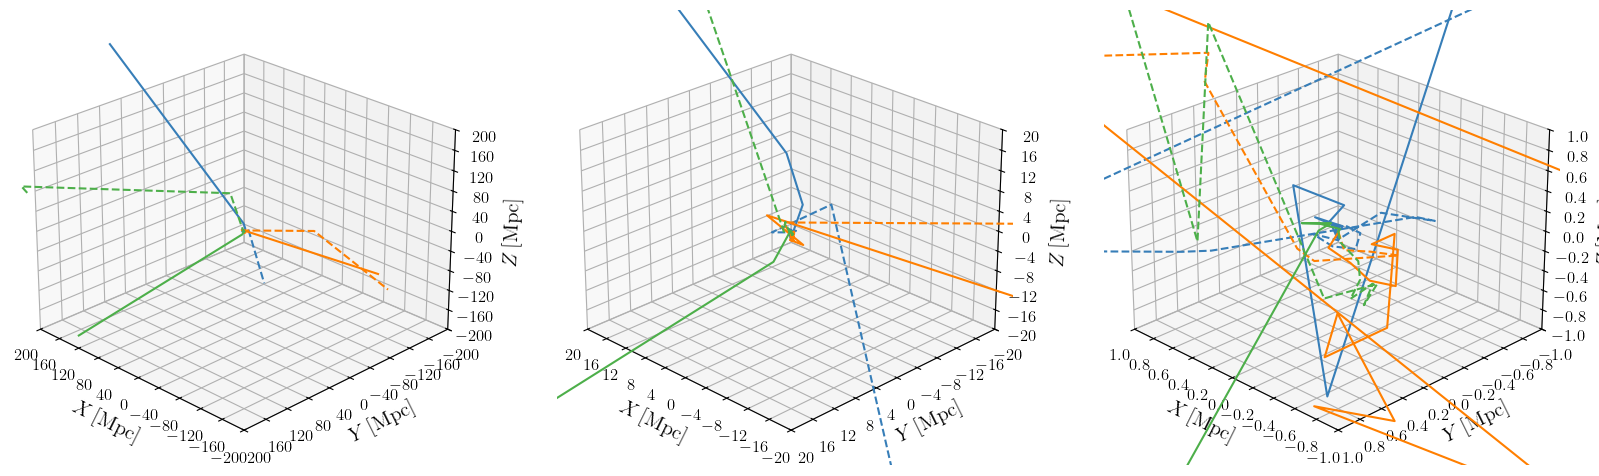

In [29]:
scales = [200,20,1]
fig = plt.figure(figsize=(20,40))
for scale_ind, scale in enumerate(scales):
    ax =  fig.add_subplot(1,3,scale_ind+1,projection='3d')
    for n in range(3):
        all_photons_data.plot_photon_trajectory(n,color=colors[n],ax=ax,scale=scale)
        all_photons_data_without_v.plot_photon_trajectory(n,color=colors[n],ax=ax,scale=scale,ls='--')
    ax.view_init(elev=25., azim=135.)

The conclusion is that while pecuilar velocities have an effect on the realizations of the photons trajectories, this effect is cancelled out when considering many photons and their statistics, e.g. the radial distributions and the window functions.